# Remove duplicate contours

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def dropDuplicateContours(segment, feed_points):
    # print('segment', segment)
    # print('feed_points', feed_points)

    splitted_segments = []
    current_segment = []

    for seg, feed in zip(segment, feed_points):
        if not feed:
            if current_segment:
                splitted_segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(seg)

    if current_segment:
        splitted_segments.append(current_segment)

    return splitted_segments

In [3]:
def dropDuplicateContours(segment, feed_points):
    splitted_segments = []
    current_segment = []

    for seg, feed in zip(segment, feed_points):
        if not feed:
            if current_segment:
                splitted_segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(seg)

    if current_segment:
        splitted_segments.append(current_segment)

    return splitted_segments

def initialize_indexes(start_point_indexes, indexes, contour_lenth):
    closest_pair = None
    min_distance = float('inf')

    for rescent_index in start_point_indexes:
        for index in indexes:
            distace = min([dist for dist in [contour_lenth - rescent_index + index, index - rescent_index] if dist > 0])
            if distace < min_distance:
                closest_pair = (rescent_index, index)
                min_distance = distace
                
    return closest_pair

def getContourApproximation(edge_image, epsilon, min_contour_len=0):

    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contour_segments = []
    for i, contour in enumerate(contours):
        # Remove contours smaller than min length
        if len(contour) < min_contour_len:
            continue

        # Edge Approximation
        approx = [tuple(point[0]) for point in cv2.approxPolyDP(contour, epsilon, True).tolist()]
        contour = [tuple(point[0]) for point in contour.tolist()]

        rescent_index = 0
        used_contour_points = None
        start_point = None

        feed_points = []
        segment = []
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i]
                segment.append(start_point)
                feed_points.append(True)

            end_point = approx[(i+1) % len(approx)]

            # Reset indexes
            indexes = np.where((np.array(contour) == end_point).all(axis=1))[0]
            if indexes.size == 0:
                break

            if i == 0:
                start_point_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]

                if len(start_point_indexes) != 1:
                    rescent_index, index = initialize_indexes(start_point_indexes, indexes, len(contour))
                else:
                    rescent_index = start_point_indexes[0]
                    closest_index = min((x for x in indexes if x >= rescent_index), default=None, key=lambda x: abs(x - rescent_index))
                    index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - 0))
            else:
                closest_index = min((x for x in indexes if x >= rescent_index), default=None, key=lambda x: abs(x - rescent_index))
                index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - 0))



            # Get the contour points of the segment
            segment_contour_points = None
            if rescent_index == index:
                segment_contour_points = [contour[index]]
            elif i == len(approx) - 1:
                segment_contour_points = contour[rescent_index:] + contour[:index]
            elif rescent_index < index:
                segment_contour_points = contour[rescent_index: index]
            elif rescent_index > index:
                 segment_contour_points = contour[rescent_index: len(contours)] + contour[0: index]
            
            # Check if Contour Points are already used
            if not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True:
                if i == 0:
                    used_contour_points = segment_contour_points
                else:
                    used_contour_points += segment_contour_points
                feed_points.append(True)
            else:
                feed_points.append(False)

            rescent_index = index + 1
            segment.append(end_point)

        contour_segments += dropDuplicateContours(segment, feed_points)

    

    return contour_segments

In [4]:
import base64
import time

preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

start_time = time.time()
contour_segments = getContourApproximation(edge_image, 1, 5)

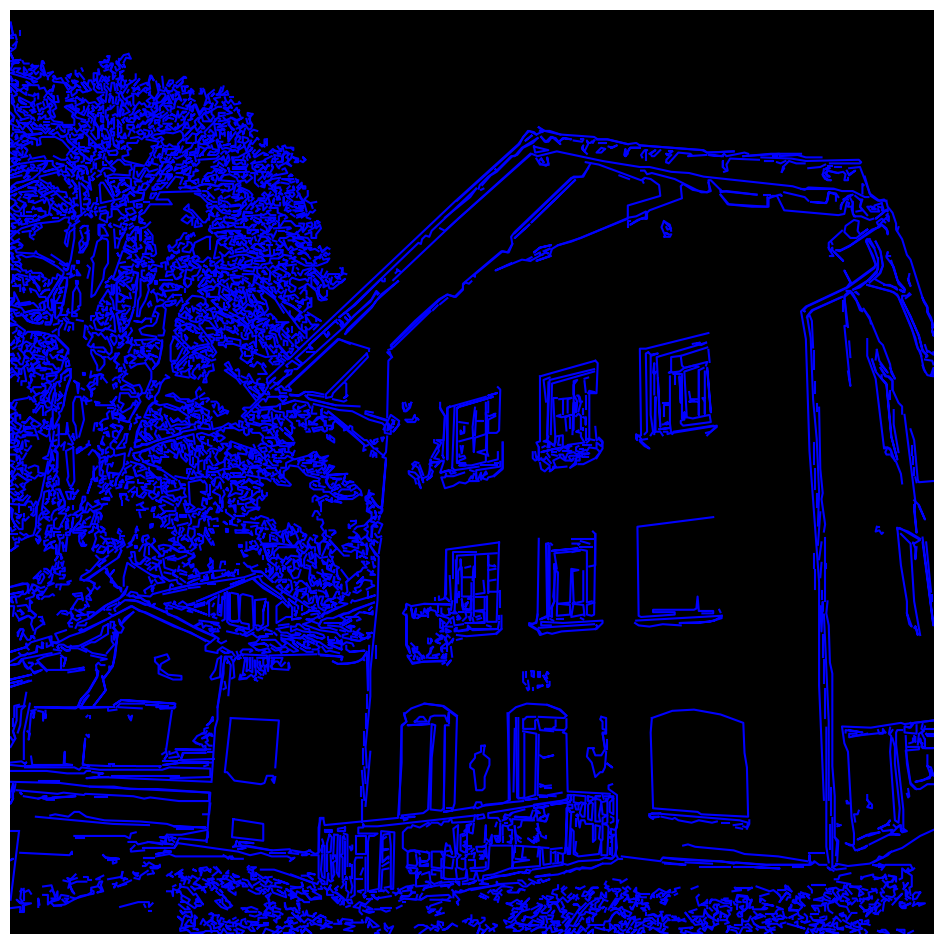

In [5]:
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(np.zeros_like(edge_image, dtype=np.uint8), cv2.COLOR_GRAY2BGR), cmap='gray')

for edge_points in contour_segments:
    x_approx = [x for x,y in edge_points]
    y_approx = [y for x,y in edge_points]
    plt.plot(x_approx, y_approx, color='blue')

plt.axis('off')
plt.show()